In [1]:
# Importing packages 
import rasterio
from rasterio.merge import merge
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
import sklearn
from skimage.filters import threshold_otsu
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from rasterio.features import rasterize
from rasterio.transform import Affine
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
import pandas as pd


# Tibet

In [2]:
# Band 3 (Green)
b3_files = [
    r"C:\Users\ameli\Downloads\Diss_Landsat_241029_143038\LC08_L2SP_143038_20241029_20241104_02_T1_SR_B3.TIF",
    r"C:\Users\ameli\Downloads\Diss_Landsat_241029_143039\LC08_L2SP_143039_20241029_20241104_02_T1_SR_B3.TIF"]
b3_srcs = [rasterio.open(fp) for fp in b3_files]
b3_mosaic, b3_transform = merge(b3_srcs)

# Band 5 (NIR)
b5_files = [r"C:\Users\ameli\Downloads\Diss_Landsat_241029_143038\LC08_L2SP_143038_20241029_20241104_02_T1_SR_B5.TIF",
            r"C:\Users\ameli\Downloads\Diss_Landsat_241029_143039\LC08_L2SP_143039_20241029_20241104_02_T1_SR_B5.TIF"]
b5_srcs = [rasterio.open(fp) for fp in b5_files]
b5_mosaic, b5_transform = merge(b5_srcs)

# Band 6 (SWIR)
b6_files = [r"C:\Users\ameli\Downloads\DissLandsat_38\LC08_L2SP_143038_20241029_20241104_02_T1_SR_B6.TIF",
            r"C:\Users\ameli\Downloads\Diss_Landsat_39_New\LC08_L2SP_143039_20241029_20241104_02_T1_SR_B6.TIF"]
b6_srcs = [rasterio.open(fp) for fp in b6_files]
b6_mosaic, b6_transform = merge(b6_srcs)

# Band 7 (SWIR2)
b7_files = [r"C:\Users\ameli\Downloads\DissLandsat_38\LC08_L2SP_143038_20241029_20241104_02_T1_SR_B7.TIF",
            r"C:\Users\ameli\Downloads\Diss_Landsat_39_New\LC08_L2SP_143039_20241029_20241104_02_T1_SR_B7.TIF"]
b7_srcs = [rasterio.open(fp) for fp in b7_files]
b7_mosaic, b7_transform = merge(b7_srcs)

# Calculating Spectral Indicies

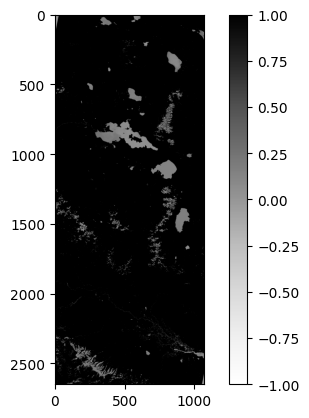

In [3]:
# Creating a function to crop the mosaic to the area of interest
def crop(mosaic):
    ilo = 1100
    ihi = ilo + 10600
    jlo = 2200
    jhi = jlo + 4280
    return mosaic[0, ilo:ihi, jlo:jhi]

b3_cropped = crop(b3_mosaic)
b5_cropped = crop(b5_mosaic)
b6_cropped = crop(b6_mosaic)
b7_cropped = crop(b7_mosaic)

# NDWI calculation

def ndwif(g,n):
    t =  (g-n)/(g+n + 1.0e-10)
    T  = 10
    return np.where(np.abs(t < T),t,np.sign(t)*T)

ndwi = ndwif(b3_cropped, b5_cropped)
# color bar
colorbar = plt.colorbar(plt.imshow(ndwi, cmap='Greys', vmin=-1, vmax=1))

plt.imshow(ndwi[::4,::4], cmap='Greys', vmin=-1, vmax=1)

In [ ]:
#Thresholding NDWI using Otsu's method
# Calculate Otsu threshold
thresh = threshold_otsu(ndwi)

# Apply threshold
binary = ndwi > thresh

# Plot results
fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(ndwi, cmap='gray')
ax[0].set_title('NDWI Scaled')
ax[0].axis('off')

ax[1].hist(ndwi.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r', linestyle='--', label=f'Threshold: {thresh}')
ax[1].legend()

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('Thresholded NDWI (Otsu)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Calucating other metrics
NDSI = Green - SWIR1/ Green + SWIR1

CSI = NIR/SWIR2

ANDSI = CSI - NDSI / CSI + NDSI

NIR = Band 5

SWIR1 = Band 6

SWIR2 = Band 7

In [4]:
NDSI = (b3_cropped - b6_cropped) / (b3_cropped + b6_cropped + 1.0e-10)
CSI = b5_cropped / (b7_cropped + 1.0e-10)
ANDSI = (CSI - NDSI) / (CSI + NDSI + 1.0e-10)


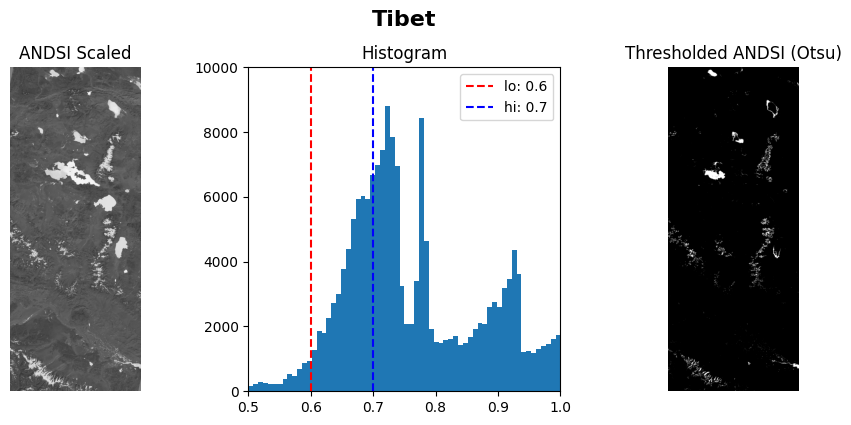

In [5]:
# Manual Thresholding ANDSI
lo = 0.6
hi = 0.7
# 3. Apply threshold
ANDSI_mask = (ANDSI > lo) & (ANDSI < hi)
#binary = ANDSI > thresh


# 4. Plot results
fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(ANDSI[::4,::4], cmap='gray')
ax[0].set_title('ANDSI Scaled')
ax[0].axis('off')

ax[1].hist(ANDSI[::4,::4].ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(lo, color='r', linestyle='--', label=f'lo: {lo}')
ax[1].axvline(hi, color='b', linestyle='--', label=f'hi: {hi}')
ax[1].set_xlim(0.5,1.0)
ax[1].set_ylim(0,1e4)
ax[1].legend()

ax[2].imshow(ANDSI_mask[::4,::4], cmap='gray')
ax[2].set_title('Thresholded ANDSI (Otsu)')
ax[2].axis('off')

plt.tight_layout()
fig.suptitle("Tibet", fontsize=16, fontweight="bold", y=1.05)
plt.show()

# Kmeans Clustering

In [ ]:
# Stack bands as features
features = np.stack([b3_cropped, b5_cropped, ndwi], axis=-1)  # shape: (rows, cols, 3)

# Flatten to 2D for clustering
rows, cols, bands = features.shape
X = features.reshape(-1, bands)

# Mask invalid data
mask = ~np.any(np.isnan(X), axis=1) & ~np.all(X == 0, axis=1)
X_valid = X[mask]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = np.full(X.shape[0], -1)  # fill with -1 (unclassified)
labels[mask] = kmeans.fit_predict(X_valid)

#  Reshape back to image
clustered = labels.reshape(rows, cols) 
glacier_mask = (clustered == 2).astype(int)  # assuming cluster 2 is glacier


# 8. Visualize
plt.imshow(clustered, cmap='tab10')
plt.title("KMeans Clustering (B3, B5, NDWI)")
plt.colorbar(label='Cluster ID')
plt.show()



# Confusion Matrix KMeans

In [ ]:
inventory = gpd.read_file(r"C:\Users\ameli\Downloads\glims_download_35962\glims_polygons.shp")
# Use the shape of the mosaic (after removing the band dimension)
out_shape = b5_mosaic.shape[1:]  # e.g. (rows, cols)

# Rasterize glacier polygons into a mask matching B5 mosaic
gandolf_mask = rasterize(
    [(geom, 1) for geom in inventory.geometry],
    out_shape=out_shape,
    transform=b5_transform,  # ✅ use this!
    fill=0,
    dtype='uint8'
)


In [ ]:
with rasterio.open(
    "glacier_mask.tif",
    "w",
    driver="GTiff",
    height=glacier_mask.shape[0],
    width=glacier_mask.shape[1],
    count=1,
    dtype='uint8',
    crs=b3_srcs[0].crs,
    transform=b5_transform  
) as dst:
    dst.write(glacier_mask, 1)

In [ ]:
# Use the shape of my glacier 
out_shape = glacier_mask.shape

# Compute cropped 
cropped_transform = b5_transform * Affine.translation(jlo, ilo)

# Reproject GANDOLF
if inventory.crs != b3_srcs[0].crs:
    inventory = inventory.to_crs(b3_srcs[0].crs)

# Rasterize GANDOLF to match your mask
gandolf_mask = rasterize(
    [(geom, 1) for geom in inventory.geometry],
    out_shape=out_shape,
    transform=cropped_transform,
    fill=0,
    dtype='uint8'
)

In [ ]:
y_kmeans = glacier_mask.flatten()
y_true = gandolf_mask.flatten()

valid = (y_true >= 0)
y_pred_valid = y_kmeans[valid]
y_true_valid = y_true[valid]

cm = confusion_matrix(y_true_valid, y_pred_valid)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-10)
recall    = TP / (TP + FN + 1e-10)
f1        = 2 * (precision * recall) / (precision + recall + 1e-10)
iou       = TP / (TP + FP + FN + 1e-10)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")


# Random Forest

In [ ]:
# Stack the input features 
X = np.stack([b3_cropped, b5_cropped, ndwi], axis=-1).reshape(-1, 3)

y = gandolf_mask.flatten()

valid = (y >= 0)
X_valid = X[valid]
y_valid = y[valid]

In [ ]:
X_train, y_train = resample(X_valid, y_valid, n_samples=100_000, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


X_train, _, y_train, _ = train_test_split(
    X_valid, y_valid, 
    train_size=100_000, 
    stratify=y_valid,     
    random_state=42
)


In [ ]:
# Predict on full image
y_pred = clf.predict(X).reshape(b3_cropped.shape)


supervised_mask = y_pred


In [ ]:
# Confusion Matrix
# Flatten both
y_true = gandolf_mask.flatten()
y_rf = supervised_mask.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_rf[valid]

# Confusion Matrix & Report
cm = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))


# Presentation

In [ ]:
# Indicies comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# NDWI
im1 = axes[0].imshow(ndwi[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[0].set_title("NDWI")
cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label("Index Value", rotation=270, labelpad=15)

# NDSI
im2 = axes[1].imshow(NDSI[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[1].set_title("NDSI")
cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label("Index Value", rotation=270, labelpad=15)

# ANDSI
im3 = axes[2].imshow(ANDSI[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[2].set_title("ANDSI")
cbar3 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label("Index Value", rotation=270, labelpad=15)

# Add panel labels A, B, C
labels = ["A", "B", "C"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

plt.tight_layout()
plt.savefig("indices_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("indices_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# NDWI Otsu
im4 = axes[0].imshow(binary[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[0].set_title("NDWI Otsu Mask")
cbar4 = fig.colorbar(im4, ax=axes[0], fraction=0.046, pad=0.04, ticks=[0,1])
cbar4.ax.set_yticklabels(["Background", "Glacier"])
cbar4.set_label("Class", rotation=270, labelpad=15)

# ANDSI
im5 = axes[1].imshow(ANDSI_mask[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[1].set_title("ANDSI Threshold Mask")
cbar5 = fig.colorbar(im5, ax=axes[1], fraction=0.046, pad=0.04, ticks=[0,1])
cbar5.ax.set_yticklabels(["Background", "Glacier"])
cbar5.set_label("Class", rotation=270, labelpad=15)

# K-Means
im6 = axes[2].imshow(glacier_mask[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[2].set_title("K-Means Mask")
cbar6 = fig.colorbar(im6, ax=axes[2], fraction=0.046, pad=0.04, ticks=[0,1])
cbar6.ax.set_yticklabels(["Background", "Glacier"])
cbar6.set_label("Class", rotation=270, labelpad=15)

# Random Forest
im7 = axes[3].imshow(supervised_mask[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Random Forest Mask")
cbar7 = fig.colorbar(im7, ax=axes[3], fraction=0.046, pad=0.04, ticks=[0,1])
cbar7.ax.set_yticklabels(["Background", "Glacier"])
cbar7.set_label("Class", rotation=270, labelpad=15)

# Panel labels
labels = ["A", "B", "C", "D"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.savefig("Methods_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("Methods_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))


bin_andsi  = 1 - ANDSI_mask.astype(int)
bin_kmeans = 1 - glacier_mask.astype(int)
bin_rf     = 1 - supervised_mask.astype(int)

# NDWI Otsu
im4 = axes[0].imshow(binary[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[0].set_title("NDWI Otsu Mask")

# ANDSI
im5 = axes[1].imshow(bin_andsi[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[1].set_title("ANDSI Threshold Mask")

# K-Means
im6 = axes[2].imshow(bin_kmeans[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[2].set_title("K-Means Mask")

# Random Forest
im7 = axes[3].imshow(bin_rf[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Random Forest Mask")

# Add panel labels
labels = ["A", "B", "C", "D"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    ax.set_xticks([]); ax.set_yticks([])

# Legend with an outline
black_patch = mpatches.Patch(facecolor='black', edgecolor='black', label='Suspected Glacier')
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Background')

fig.legend(handles=[white_patch, black_patch],
           loc='lower center', ncol=2, frameon=True)

plt.tight_layout(rect=[0, 0.12, 1, 1])  

plt.tight_layout()
plt.savefig("Methods_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("Methods_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Confusion matrix 
# Andsi Thresholding
# Confusion Matrix
# Flatten both
y_true = gandolf_mask.flatten()
y_andsi = ANDSI_mask.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_andsi[valid]

# Confusion Matrix & Report
cm1 = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm1)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))

In [ ]:
# NDWI
# Confusion Matrix
# Flatten both
y_true = gandolf_mask.flatten()
y_NDWI = binary.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_NDWI[valid]

# Confusion Matrix & Report
cm = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))

In [ ]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-10)
recall    = TP / (TP + FN + 1e-10)
f1        = 2 * (precision * recall) / (precision + recall + 1e-10)
iou       = TP / (TP + FP + FN + 1e-10)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")

In [ ]:
TP = cm1[1, 1]
TN = cm1[0, 0]
FP = cm1[0, 1]
FN = cm1[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-10)
recall    = TP / (TP + FN + 1e-10)
f1        = 2 * (precision * recall) / (precision + recall + 1e-10)
iou       = TP / (TP + FP + FN + 1e-10)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")

In [ ]:
def confusion_metrics(y_true, y_pred):
    """
    Compute confusion matrix metrics for binary classification.
    Assumes: 1 = glacier, 0 = background
    """
    y_true = y_true.astype(np.uint8).ravel()
    y_pred = y_pred.astype(np.uint8).ravel()

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    eps = 1e-9
    acc  = (tp + tn) / (tp + tn + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    iou  = tp / (tp + fp + fn + eps)
    spec = tn / (tn + fp + eps)

    # Robust MCC
    denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if denom == 0:
        mcc = 0.0
    else:
        mcc = (tp*tn - fp*fn) / denom

    return {
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "IoU_glacier": iou,
        "Specificity": spec,
        "MCC": mcc
    }

In [ ]:
results = {
    "NDWI Otsu": confusion_metrics(y_true, y_NDWI),
    "ANDSI":     confusion_metrics(y_true, y_andsi),
    "KMeans":    confusion_metrics(y_true, y_kmeans),
    "RandomForest": confusion_metrics(y_true, y_rf)
}

df = pd.DataFrame(results).T[
    ["Accuracy","Precision","Recall","F1","IoU_glacier","MCC"]
]

print(df.round(3))

In [ ]:
# Picking only key metrics
cols = ["Accuracy","Precision","Recall","F1","IoU_glacier"]

df = pd.DataFrame(results).T[cols].copy()
df = df.astype(float).round(3)
df = df.replace([np.inf, -np.inf], np.nan).fillna("—")

# Renaming to remove MCC
df = df.rename(columns={
    "F1": "F1 Score",
    "IoU_glacier": "IoU"
})
df = df.rename(index={
    "NDWI Otsu": "NDWI (Otsu)",
    "ANDSI": "ANDSI (Thres.)",
    "KMeans": "K-Means",
    "RandomForest": "Random Forest"
})

# Move index into a column
df.insert(0, "Method", df.index)
df.reset_index(drop=True, inplace=True)

# Plotting table
n_rows, n_cols = df.shape
fig, ax = plt.subplots(figsize=(1.2*n_cols, 0.5 + 0.5*n_rows))
ax.axis("off")

the_table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc="center",
    cellLoc="center"
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.2)

# Bold headers
for j in range(n_cols):
    the_table[(0, j)].set_text_props(weight="bold")

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig("metrics_table_tibet.png", dpi=300, bbox_inches="tight")
plt.savefig("metrics_table_tibet.pdf", dpi=300, bbox_inches="tight")
plt.show()